In [1]:
import json
import os
import pandas as pd
import numpy as np
from enum import Enum
import copy

from math import ceil
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.tsa import stattools

In [2]:
font_size = 16
# plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': font_size, 
                     'axes.edgecolor': 'white',
                     'axes.grid': True})

colorscale = px.colors.qualitative.Dark24
pio.templates.default = "plotly_white"

In [3]:
class Apis(str, Enum):
    OPEN_SENSE_MAP = "2889936e-8e2d-11ee-b9d1-0242ac120002"
    SENSOR_COMMUNITY = "017f12f5-8acb-4531-ab77-0e5208a31bca"
    TELRAAM = "8c9a8f25-e54e-4884-aee6-a4529c5424ba"

out_dir = "./all_out"

# Overview

There are a number of Apis that we are pulling from. In a previous process I already removed all the data that is not geolocated inside of our prdefined square around Berlin. And now im proceding to look at sensor community data specifically.

In [4]:
sc_df = pd.DataFrame(columns=["timesent","timestamp","latitude","longitude","altitude","id","sensor-name","sensor-manufacturer"])


sensor_community_value_types = [
    "P1",
    "P2",
    "humidity",
    "temperature",
    "pressure",
    "pressure_at_sealevel",
    "counts",
    "counts_per_minute",
    "hv_pulses",
    "sample_time_ms",
    "noise_LAeq",
    "noise_LA_max",
    "noise_LA_min",
    "co2_ppm"
]

dirs = os.listdir(out_dir)
for dir in dirs:
    if dir == Apis.SENSOR_COMMUNITY:
        for file in os.listdir(f"{out_dir}/{dir}"):
            with open(f"{out_dir}/{dir}/{file}") as f:
                request = json.loads(f.read())
                body = request["body"]
                all_data = []
                for record in body:
                    data = {}
                    data["timesent"] = request["timeSent"]
                    data["timestamp"] = record["timestamp"]
                    data["latitude"] = record["location"]["latitude"]
                    data["longitude"] = record["location"]["longitude"]
                    data["altitude"] = record["location"]["altitude"]
                    data["id"] = record["id"]
                    data["sensor-name"] = record["sensor"]["sensor_type"]["name"]
                    data["sensor-manufacturer"] = record["sensor"]["sensor_type"]["manufacturer"]
                    for value in record["sensordatavalues"]:
                        no_hit = True
                        for val_type in sensor_community_value_types:
                            if val_type == value["value_type"]:
                                no_hit = False
                                data[val_type] = value["value"]
                        if no_hit:
                            print(f"new value: {value}")
                    all_data.append(data)
                sc_df = pd.concat(
                    [sc_df, pd.DataFrame(all_data)],
                    ignore_index=True
                )

sc_df.head()

,timesent,timestamp,latitude,longitude,altitude,id,sensor-name,sensor-manufacturer,P1,P2,...,pressure,pressure_at_sealevel,counts,counts_per_minute,hv_pulses,sample_time_ms,noise_LAeq,noise_LA_max,noise_LA_min,co2_ppm
0,2023-12-07T11:03:39.693507,2023-12-07 10:02:11,52.516,13.426,37.0,18272861646,SDS011,Nova Fitness,7.20,5.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-12-07T11:03:39.693507,2023-12-07 10:01:50,52.568,13.402,45.0,18272858796,SDS011,Nova Fitness,56.38,28.36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-12-07T11:03:39.693507,2023-12-07 10:01:50,52.568,13.402,45.0,18272858826,DHT22,various,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-12-07T11:03:39.693507,2023-12-07 10:02:44,52.502,13.488,37.6,18272868058,SDS011,Nova Fitness,29.66,20.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-12-07T11:03:39.693507,2023-12-07 10:02:45,52.502,13.488,37.6,18272868579,DHT22,various,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Info about sensor community
The data provided by this api is very diverse. The `sensor_community_value_types` array shows just how many different types of values are present in the data and in the graph below you can see just how many values are missing for every single measuemrent also relative to how many values there are in total.

All of that said, I came to the conclusion that since the data is so inconsistent one way would be to aggregate the data to the grid squares for Berlin that we predefined. There squares would make it possible ot aggregate different sensors into one single row that would the in more cases be filled out without holes. The problem here is that outliers would skew this data in the wrong directions to outlier detection and removal would have to happen before that.

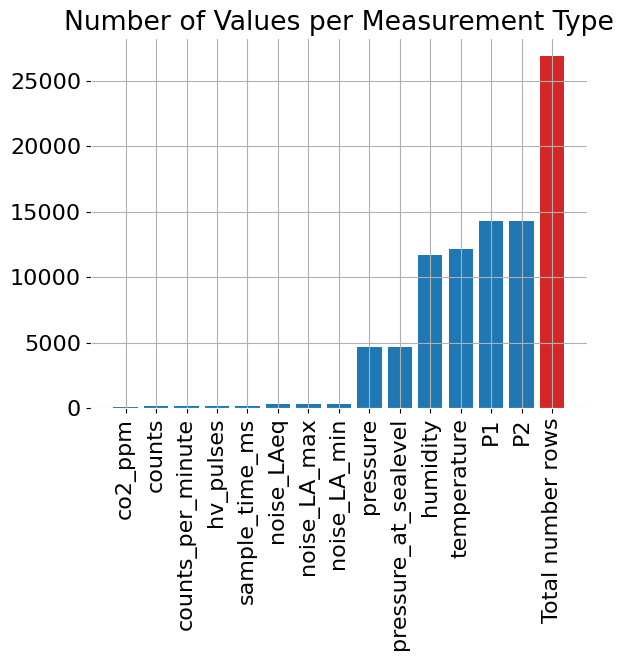

In [5]:
counts = sc_df[sensor_community_value_types].count().sort_values()
labels = [*counts.index, "Total number rows"]
values = [*np.array(counts), sc_df.shape[0]]
bar_colors = [*(['tab:blue'] * len(counts.index)), 'tab:red']
fig, ax = plt.subplots()
ax.set_title('Number of Values per Measurement Type')
ax.bar(labels,values,color=bar_colors)
plt.xticks(rotation=90)
plt.show()

In [6]:
sensor_community = copy.deepcopy(sc_df)
sensor_community["location"] = [touple for touple in zip(sensor_community["latitude"],sensor_community["longitude"])]
sensor_community = sensor_community.drop(["counts","counts_per_minute","hv_pulses","sample_time_ms","noise_LAeq","noise_LA_max","noise_LA_min","co2_ppm", "latitude", "longitude"], axis=1)
sensor_community = sensor_community.set_index(["timesent", "timestamp", "altitude", "id", "sensor-name", "sensor-manufacturer", "location"])
sensor_community

P1  \
timesent                   timestamp           altitude id          sensor-name sensor-manufacturer location                                  
2023-12-07T11:03:39.693507 2023-12-07 10:02:11 37.0     18272861646 SDS011      Nova Fitness        (52.516, 13.426)                   7.20   
                           2023-12-07 10:01:50 45.0     18272858796 SDS011      Nova Fitness        (52.568, 13.402)                  56.38   
                                                        18272858826 DHT22       various             (52.568, 13.402)                    NaN   
                           2023-12-07 10:02:44 37.6     18272868058 SDS011      Nova Fitness        (52.502, 13.488)                  29.66   
                           2023-12-07 10:02:45 37.6     18272868579 DHT22       various             (52.502, 13.488)                    NaN   
...                                                                                                                                     ...   
2023-12-07T16:24:05.529442 2023-12-07 15:22:26 52.7     18275876871 DHT22       various             (52.54, 13.416)                     NaN   
                           2023-12-07 15:21:31 37.5     18275868361 SDS011      Nova Fitness        (52.49634568906, 13.43316257000)  77.63   
                                                        18275868374 BME280      Bosch               (52.49634568906, 13.43316257000)    NaN   
                           2023-12-07 15:22:02 38.7     18275872589 SDS011      Nova Fitness        (52.514, 13.468)                  46.68   
                           2023-12-07 15:22:03 38.7     18275872650 BME280      Bosch               (52.514, 13.468)                    NaN   

                                                                                                                                         P2  \
timesent                   timestamp           altitude id          sensor-name sensor-manufacturer location                                  
2023-12-07T11:03:39.693507 2023-12-07 10:02:11 37.0     18272861646 SDS011      Nova Fitness        (52.516, 13.426)                   5.01   
                           2023-12-07 10:01:50 45.0     18272858796 SDS011      Nova Fitness        (52.568, 13.402)                  28.36   
                                                        18272858826 DHT22       various             (52.568, 13.402)                    NaN   
                           2023-12-07 10:02:44 37.6     18272868058 SDS011      Nova Fitness        (52.502, 13.488)                  20.72   
                           2023-12-07 10:02:45 37.6     18272868579 DHT22       various             (52.502, 13.488)                    NaN   
...                                                                                                                                     ...   
2023-12-07T16:24:05.529442 2023-12-07 15:22:26 52.7     18275876871 DHT22       various             (52.54, 13.416)                     NaN   
                           2023-12-07 15:21:31 37.5     18275868361 SDS011      Nova Fitness        (52.49634568906, 13.43316257000)  31.62   
                                                        18275868374 BME280      Bosch               (52.49634568906, 13.43316257000)    NaN   
                           2023-12-07 15:22:02 38.7     18275872589 SDS011      Nova Fitness        (52.514, 13.468)                  17.80   
                           2023-12-07 15:22:03 38.7     18275872650 BME280      Bosch               (52.514, 13.468)                    NaN   

                                                                                                                                     humidity  \
timesent                   timestamp           altitude id          sensor-name sensor-manufacturer location                                    
2023-12-07T11:03:39.693507 2023-12-07 10:02:11 37.0     18272861646 SDS011      Nova Fitness        (52.516, 13.426)           

In [7]:
def describe(df):
    general_stats = df.describe().T
    general_stats = general_stats.sort_index()
    delete_cols = ['25%', '50%', '75%']
    general_stats = general_stats.drop(delete_cols, axis=1)
    
    #general_stats = general_stats.rename({'count': 'perc missing'}, axis=1)
    
    styled_general_stats = general_stats.style.background_gradient(cmap='Blues', axis=None, subset=['count',])
    styled_general_stats = styled_general_stats.background_gradient(cmap='Greens', axis=None, subset=['mean',])
    styled_general_stats = styled_general_stats.background_gradient(cmap='Reds', axis=None, subset=['std',])
    styled_general_stats = styled_general_stats.background_gradient(cmap='Purples', axis=None, subset=['min',])
    styled_general_stats = styled_general_stats.background_gradient(cmap='Greys', axis=None, subset=['max',])
    return styled_general_stats.format({
            'perc missing' : '{:,.2f}', 
            'mean' : '{:.2f}',
            'std' : '{:.2f}', 
            'min' : '{:.2f}',
            'max' : '{:.2f}'
    })

# Finding outliers

In [8]:
describe(sensor_community.astype(float).dropna(how="all"))

,count,mean,std,min,max
P1,14277.000000,65.55,171.93,0.00,1999.90
P2,14277.000000,29.55,85.27,0.00,999.90
humidity,11676.000000,88.14,21.62,0.00,118.99
pressure,4664.000000,95350.25,19748.79,-12695.97,102225.00
pressure_at_sealevel,4665.000000,95878.14,19805.04,-12831.03,102752.54
temperature,12156.000000,-1.18,29.49,-147.84,36.60


## Narrowing down the dataset
As mentioned above the this information is not very reppresentative so I will first focus in P1 and P2. The names of these are confusing but they are actually PM10 and PM2.5 measurements as can be found in the documentation sheet of the sensor models that provide them.
Here is also a explenation of what the values mean, found [here](https://www.irceline.be/en/documentation/faq/what-is-pm10-and-pm2.5):

> Particulate matter such as PM10, PM2.5, PM1 and PM0.1 is defined as the fraction of particles with an aerodynamic diameter smaller than respectively 10, 2.5, 1 and 0.1 µm

In [9]:
particles = sensor_community[["P1", "P2"]].dropna().astype(float)
describe(particles)

,count,mean,std,min,max
P1,14274.000000,65.56,171.94,0.00,1999.90
P2,14274.000000,29.55,85.28,0.00,999.90


# Particles in the air
Looking at some [sources](https://www.epa.vic.gov.au/for-community/environmental-information/air-quality/pm10-particles-in-the-air) for PM10 ranges, I found that values over 300 are considered "very poor airquality". Considering that there are quite a view values that are in that cathegory but then again they are not that far from the expected range that I would writ them off as outliers.

As for PM2.5 values the [found](https://climate-adapt.eea.europa.eu/en/observatory/evidence/projections-and-tools/cams-ground-level-pm2.5-forecast/cams-pm25-viewer) range should be from 10 to 50 which also corresponds to the visible range.

The extreme cutoff at both 2000 and 1000 respectivelty is in my opinion because of the sensors capabilities to sense particles at numbers higher then that.


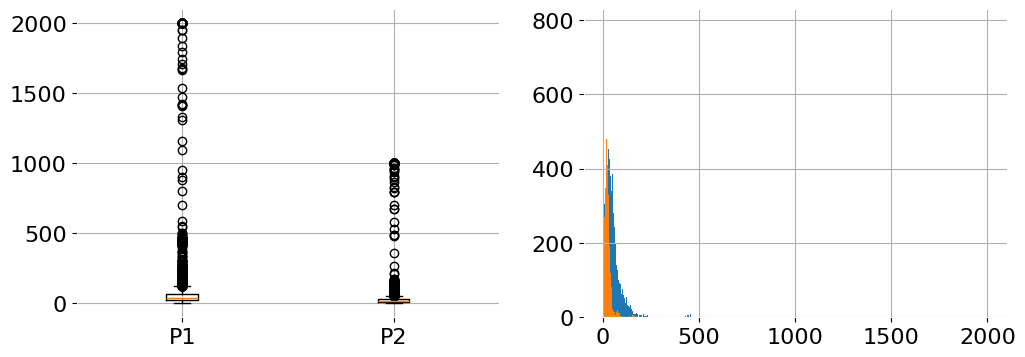

In [10]:
fig, (boxplot, hist) = plt.subplots(1,2, figsize=(12, 4))
boxplot.boxplot(particles, labels=particles.columns)

hist.hist(particles["P1"], label="PM10", bins=1000)
hist.hist(particles["P2"], label="PM2.5", bins=1000)

plt.show()

# Temperature
Compared to the paricle data here I can clearly see some outliers, especially since they are soo far off that it is physically impossible for them to be true values.

In [22]:
temp = sensor_community[["temperature"]].dropna().astype(float)
describe(temp)

,count,mean,std,min,max
temperature,12156.000000,-1.18,29.49,-147.84,36.60


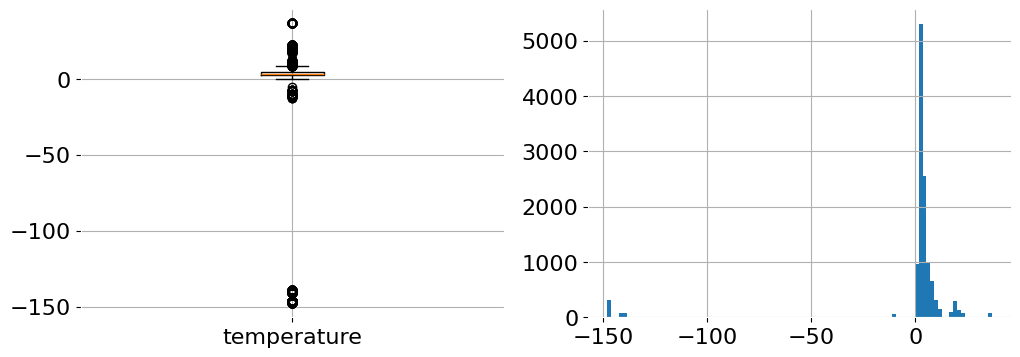

In [24]:
fig, (boxplot, hist) = plt.subplots(1,2, figsize=(12, 4))
boxplot.boxplot(temp, labels=temp.columns)

hist.hist(temp["temperature"], label="temperature", bins=100)

plt.show()

Looking at the temperature values by sensor type we can clearly see that the `BME280` sensor is the one providing the faulty data. To fix this I think we only need to exclude all data after a certain point, maybe something like -20 since I can see -10 happening in berlin on a very cold day.

An other observation are the values of the `DHT22` sensor which also seem to have a lot of values outside a expected range for outside temperatures on a winter day. There values are probably due to the sensor either beeing indoors or close to a indoor space that leaks heat to the outside.

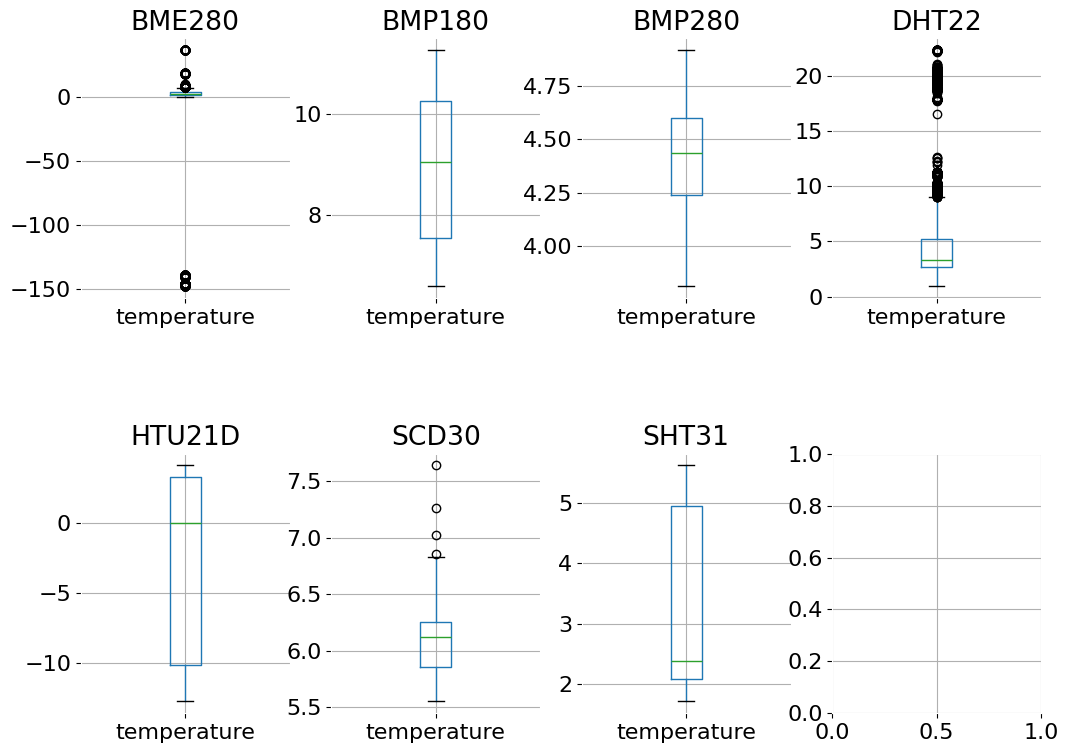

In [31]:
fig_cols = 4
temp_by_sensor = temp.groupby(level=4)
grid = (ceil(len(temp_by_sensor) / fig_cols), fig_cols)
fig, ax = plt.subplots(*grid, figsize=(12, 9), gridspec_kw={'hspace': .6})
used_axes = ax[np.unravel_index(range(len(temp_by_sensor)), grid)]
_ = temp_by_sensor.boxplot(ax=used_axes, sharey=False)

# Humidity
Here the values should be very simple since the range is a simple 0%-100% but as we will see some of these sensors are not recording correctly.

Please also consider that the values can never really reach 0 but they can reach 100. So already looking at the overall boxplot and histogram something is wrong as there are values above 100 and values that are 0.

In [41]:
hum = sensor_community[["humidity"]].dropna().astype(float)
describe(hum)

,count,mean,std,min,max
humidity,11676.000000,88.14,21.62,0.00,118.99


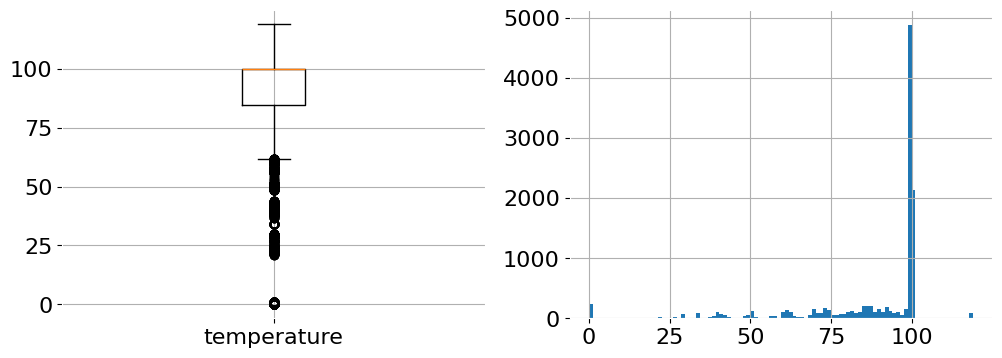

In [26]:
fig, (boxplot, hist) = plt.subplots(1,2, figsize=(12, 4))
boxplot.boxplot(hum, labels=temp.columns)

hist.hist(hum["humidity"], label="humidity", bins=100)

plt.show()

Looking at the sensors specifically we can see that the first three are the culprits. Both the `BME280` and the `DHT22` have values that are 0 but other then that their ranges are quite normal. The `HTU21D` on the otherhand has something truly wrong as its range completly spans from above 100 right to 0.

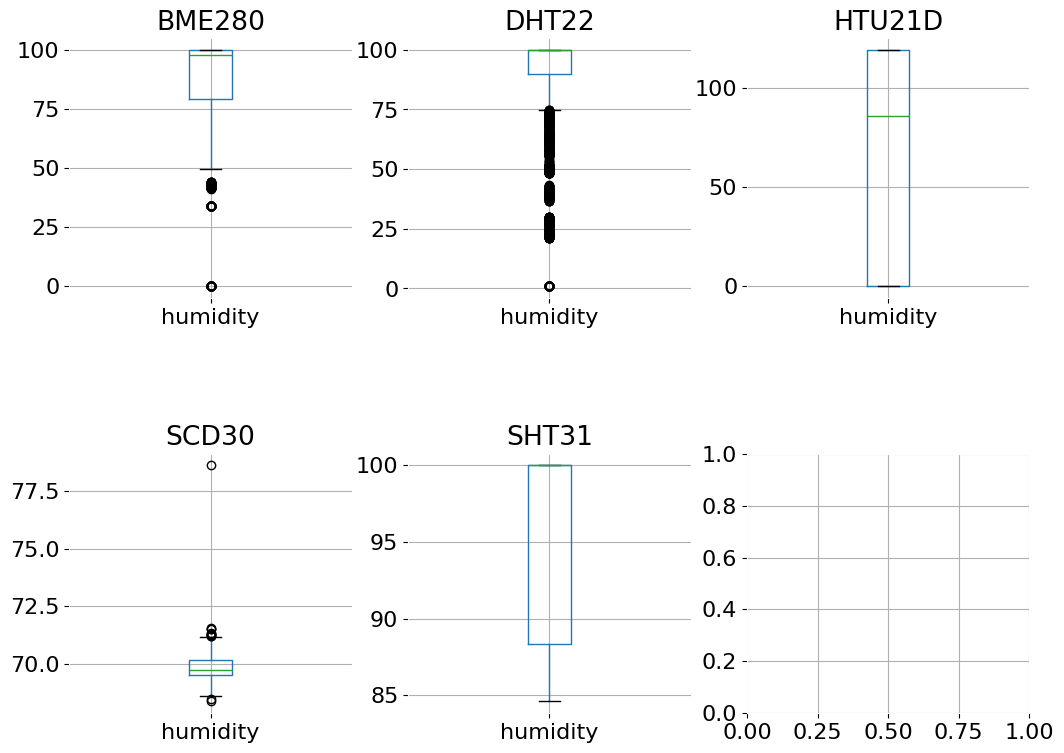

In [42]:
fig_cols = 3
hum_by_sensor = hum.groupby(level=4)
grid = (ceil(len(hum_by_sensor) / fig_cols), fig_cols)
fig, ax = plt.subplots(*grid, figsize=(12, 9), gridspec_kw={'hspace': .6})
used_axes = ax[np.unravel_index(range(len(hum_by_sensor)), grid)]
_ = hum_by_sensor.boxplot(ax=used_axes, sharey=False)


Looking at the `HTU21D` in the histogram we can also clearly see what the problem is. Surprisingly this will be easy to fix since we can just cut off all the values that are above 100 and the ones that are 0.

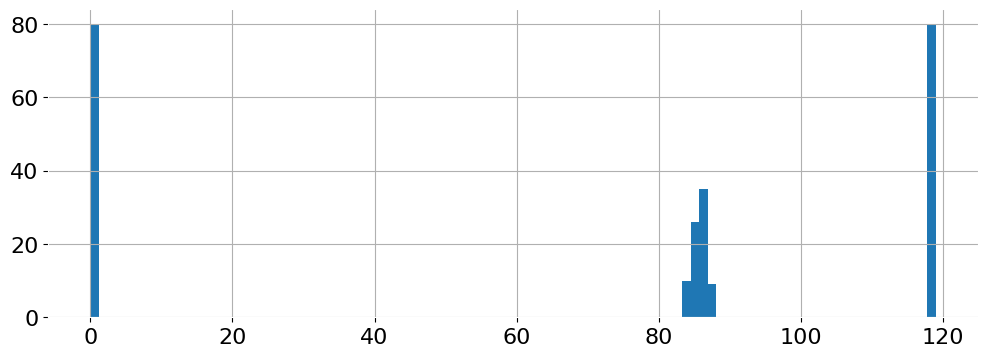

In [40]:
HTU21D = hum[np.in1d(hum.index.get_level_values(4), ["HTU21D"])]
fig, hist = plt.subplots(1,1, figsize=(12, 4))
hist.hist(HTU21D["humidity"], label="humidity", bins=100)
plt.show()